## Data Pipelines - Prefect - Example and Workshop
### Big Data Tools 
#### M.Sc. in Applied Analytics (coterminal course)
Fac. de Ingeniería -  Universidad de la Sabana<br>
Prof.: Hugo Franco, Ph.D.

In [ ]:
import os
import time
import logging
import pandas as pd
from prefect import flow, task, get_run_logger
from kaggle import KaggleApi

# Environment setup
os.environ['OMP_NUM_THREADS'] = '1'  # Prevent problems with threading

# Constants
LOCAL_KAGGLE_DIR = './auth'
DOWNLOAD_DIRECTORY = './data'
TARGET_DATASET = 'sushilyeotiwad/wheat-seed-dataset'

# Timing decorator to report task duration
def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        duration = end_time - start_time
        print(f"Task '{func.__name__}' took {duration:.4f} seconds")
        return result
    return wrapper

# Task: Create download directory
@task(name="Create Download Directory")
@timing_decorator
def create_download_directory():
    logger = get_run_logger()
    try:
        if not os.path.exists(DOWNLOAD_DIRECTORY):
            logger.info(f"Creating directory: {DOWNLOAD_DIRECTORY}")
            os.makedirs(DOWNLOAD_DIRECTORY)
        else:
            logger.info(f"Directory {DOWNLOAD_DIRECTORY} already exists.")
    except Exception as e:
        logger.error(f"Failed to create directory {DOWNLOAD_DIRECTORY}: {str(e)}")
        raise
    finally:
        logger.info("Directory creation task completed.")

# Task: Authenticate with Kaggle
@task(retries=3, retry_delay_seconds=10, name="Authenticate")
@timing_decorator
def api_authenticate():
    logger = get_run_logger()
    try:
        logger.info("Attempting Kaggle API authentication...")
        api = KaggleApi()
        api.authenticate()
        logger.info("Kaggle API authentication successful.")
        return api
    except Exception as e:
        logger.error(f"Kaggle authentication failed: {str(e)}")
        raise
    finally:
        logger.info("Authentication task completed.")

# Task: Download dataset from Kaggle
@task(retries=3, retry_delay_seconds=10, name="Download Dataset")
@timing_decorator
def download_dataset(kaggle_api):
    logger = get_run_logger()
    try:
        logger.info(f"Downloading dataset '{TARGET_DATASET}' to '{DOWNLOAD_DIRECTORY}'...")
        kaggle_api.dataset_download_files(TARGET_DATASET, path=DOWNLOAD_DIRECTORY, unzip=True)
        logger.info("Dataset download and unzip completed successfully.")
    except Exception as e:
        logger.error(f"Dataset download failed: {str(e)}")
        raise
    finally:
        logger.info("Download task completed.")

# Task: Load CSV into DataFrame
@task(name="Load CSV")
@timing_decorator
def load_csv():
    logger = get_run_logger()
    try:
        os.chdir(DOWNLOAD_DIRECTORY)
        logger.info(f"Loading CSV file from {DOWNLOAD_DIRECTORY}/seeds_dataset.csv")
        df_seeds = pd.read_csv('seeds_dataset.csv')
        logger.info("CSV file loaded successfully.")
        return df_seeds
    except FileNotFoundError as e:
        logger.error(f"CSV file not found: {str(e)}")
        raise
    except Exception as e:
        logger.error(f"Error loading CSV: {str(e)}")
        raise
    finally:
        logger.info("CSV loading task completed.")

# Task: Transform data (cleansing)
@task(name="Transform Data")
@timing_decorator
def transform_data(df_seeds):
    logger = get_run_logger()
    try:
        logger.info("Performing data cleansing...")
        # Basic data cleansing: Drop the 'Class' column
        df_clustering = df_seeds.drop('Class_(1, 2, 3)', axis=1)
        # Additional cleansing: Handle missing values and duplicates
        df_clustering = df_clustering.dropna().drop_duplicates()
        logger.info("Data cleansing completed.")
        return df_clustering
    except KeyError as e:
        logger.error(f"Column not found during transformation: {str(e)}")
        raise
    except Exception as e:
        logger.error(f"Transformation failed: {str(e)}")
        raise
    finally:
        logger.info("Data transformation task completed.")

# Main Flow: Orchestrate the pipeline
@flow(name="Wheat Seed Extract Pipeline")
def extract_data():
    create_download_directory()
    kaggle_api = api_authenticate()
    download_dataset(kaggle_api)
    df_seeds = load_csv()
    df_clustering = transform_data(df_seeds)
    return df_clustering

# Run the flow
if __name__ == "__main__":
    df_clustering = extract_data()

Creating directory: ./data


09:56:18.194 | INFO    | prefect - Starting temporary server on http://127.0.0.1:8419
See https://docs.prefect.io/v3/concepts/server#how-to-guides for more information on running a dedicated Prefect server.

09:56:24.205 | INFO    | Flow run 'adept-quail' - Beginning flow run 'adept-quail' for flow 'extract-data'

09:56:24.836 | INFO    | Task run 'Authenticate-0ea' - Finished in state Completed()

Dataset URL: https://www.kaggle.com/datasets/sushilyeotiwad/wheat-seed-dataset


09:56:25.442 | INFO    | Flow run 'adept-quail' - Finished in state Completed()

### Basic (Unsupervised) Machine Learning analytics method
 Determine, by clustering, a sound number of species within the wheat seed dataset

 Firstly, identify the less correlated pair of features and use them as the representation for the instances in the dataset

The lowest absolute correlation is 0.0111, between ('Length_of_kernel_groove', 'Asymmetry_coefficient')


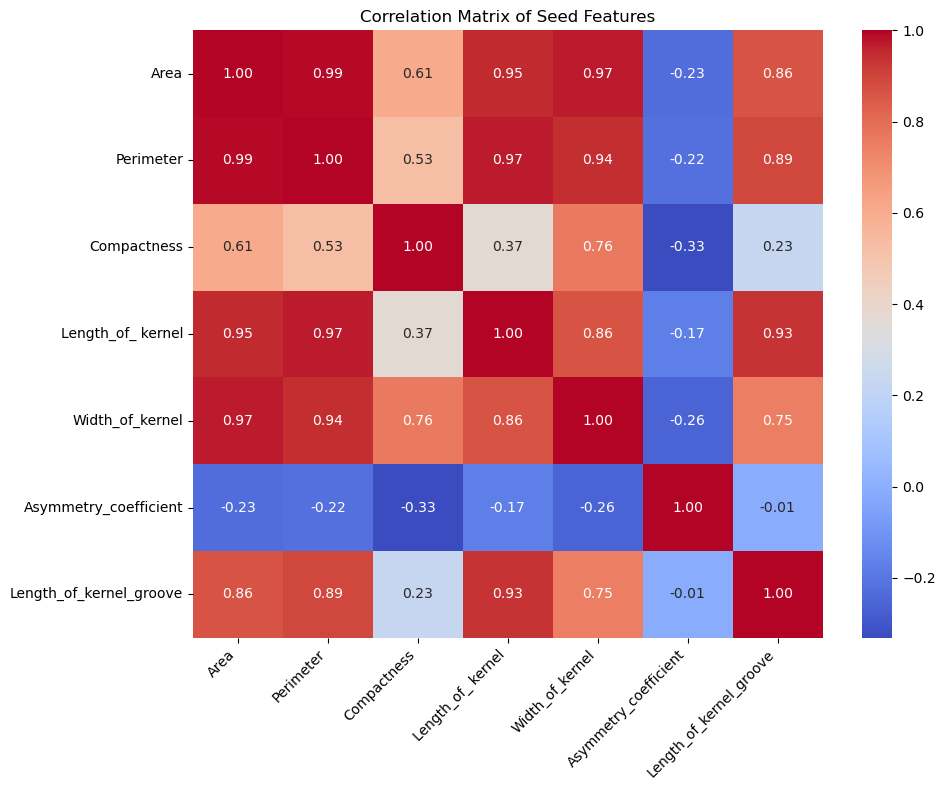

In [2]:
# Calculate the correlation matrix.
correlation_matrix = df_clustering.corr()

# Find the pair of variables with the lowest absolute correlation.
# We take the upper triangle of the correlation matrix and flatten it, and ignore the diagonal (which are all 1).
# We then find the minimum value and the corresponding row and column.
lower_triangle = correlation_matrix.mask(np.triu(np.ones(correlation_matrix.shape)).astype(bool))
lowest_corr = lower_triangle.stack().abs().min()
lowest_corr_pair = lower_triangle.stack().abs().idxmin()

# Print the lowest correlation and the corresponding pair of variables.
print(f"The lowest absolute correlation is {lowest_corr:.4f}, between {lowest_corr_pair}")

# Plot a heatmap of the correlation matrix for visualization.
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Seed Features')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('correlation_heatmap.png')
plt.show()

Now, use the `KMeans` clustering method to perform an unsupervised approach to the identification of the number of species in the dataset, according to the observations 

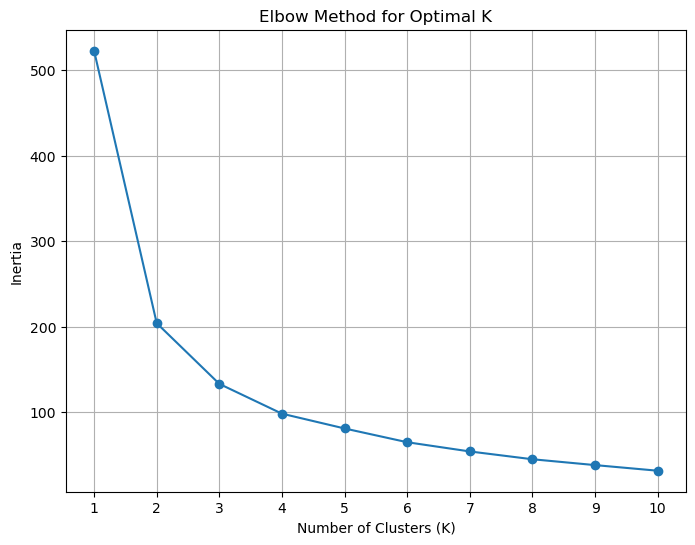

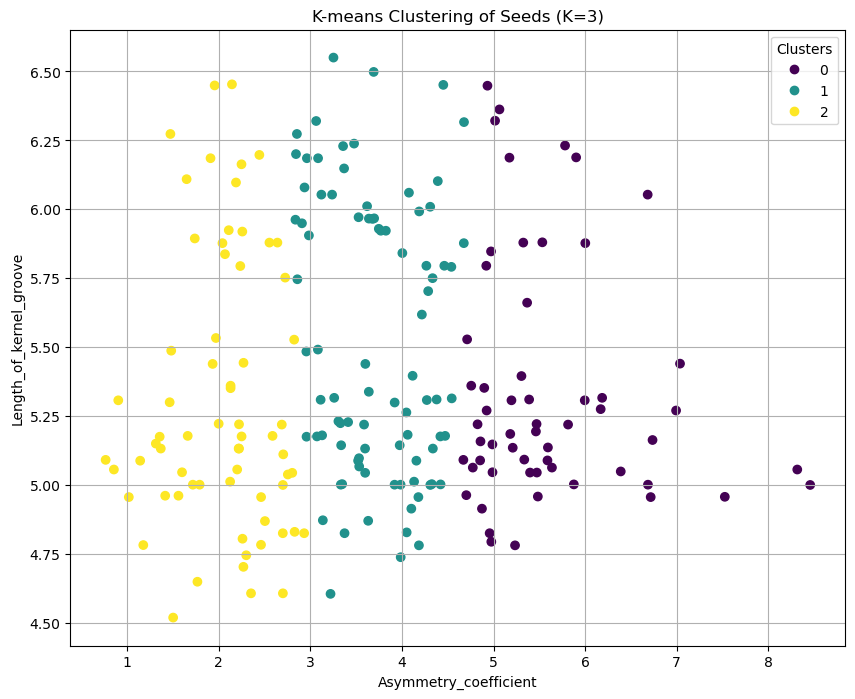

In [3]:
# Select the two variables for clustering.
X = df_clustering[['Asymmetry_coefficient', 'Length_of_kernel_groove']]

# Determine the optimal number of clusters using the Elbow Method.
inertia = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method results.
plt.figure(figsize=(8, 6))
plt.plot(range(1, 11), inertia, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia')
plt.xticks(range(1, 11))
plt.grid(True)
plt.savefig('elbow_method.png')
plt.show()

# Based on the Elbow plot, choose the optimal number of clusters.
# For this dataset, the 'Class' column suggests ?? classes, and the elbow method plot shows a good elbow at k=??.
optimal_k = 3

# Perform K-means clustering with the optimal number of clusters.
kmeans_model = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df_clustering['cluster'] = kmeans_model.fit_predict(X)

# Visualize the clustering results.
plt.figure(figsize=(10, 8))
scatter = plt.scatter(df_clustering['Asymmetry_coefficient'], df_clustering['Length_of_kernel_groove'], c=df_clustering['cluster'], cmap='viridis')
plt.title('K-means Clustering of Seeds (K=3)')
plt.xlabel('Asymmetry_coefficient')
plt.ylabel('Length_of_kernel_groove')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.grid(True)
plt.savefig('kmeans_clustering_plot.png')
plt.show()



__Challenges (Workshop 3, part 2):__
1. Organize the code of the example and complete the data pipeline: 
    - Use `try-except-finally` blocks as required 
    - Every individual process must be wrapped as a `task` using the corresponding decorator and its parameters when necessary. 
    - Create a `transform_data` task focused on data cleansing
    - Create a `load_data` task to create a table in a Dockerized PostgreSQL database and populate with with the clustering-oriented Dataframe
    - Invoke the tasks in the proper order in the `flow`
    - Use the `timing_decorator` to report the duration of each task 
1. Using the function get_directory_size, create a decorator to get and report the size of the downloaded dataset (size in bytes of the download folder)
1. Report the size in the previous question in a human readable unit
1. Use the attribute kmeans.cluster_centers_ and scatter plot to add the centroids of the best KMeans model (best K parameter) to the scatter plot
    - `centroids = kmeans.cluster_centers_`


In [ ]:
def get_directory_size(path='.'):
    total_size = 0
    for dirpath, dirnames, filenames in os.walk(path):
        for f in filenames:
            # Create the full file path by joining the directory path and file name
            fp = os.path.join(dirpath, f)
            # Skip symbolic links to avoid counting them
            if not os.path.islink(fp):
                total_size += os.path.getsize(fp)
    return total_size    